Code based on Erlend Magnus Viggen, Erlend Hårstad, Jørgen Kvalsvik

**Getting started with acoustic well log data using the dlisio Python library on the Volve Data Village dataset**

https://github.com/equinor/dlisio-notebooks/blob/master/acoustic.ipynb

There is an alternative to read dlis files with [dlispy](https://github.com/Teradata/dlispy)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install dlisio

     |████████████████████████████████| 440kB 5.6MB/s 


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import dlisio
import pandas as pd
import numpy as np
import scipy.signal as signal
import logging
import copy

In [4]:
%matplotlib inline

In [5]:
pd.set_option('display.max_rows', 500)

In [6]:
filepath = r'/content/drive/MyDrive/Colab_Data/WL_RAW_PROD_AC-AIMG-CCL-GR_2013-06-05_2.DLIS'

Set encoding to avoid errors reading parameters such as: 

```
/usr/local/lib/python3.7/dist-packages/dlisio/plumbing/parameter.py:130: UnicodeWarning: unable to decode string b'58\xb0 26\' 29.96" N'
  values = self.attic['VALUES'].value
/usr/local/lib/python3.7/dist-packages/dlisio/plumbing/parameter.py:130: UnicodeWarning: unable to decode string b'1\xb0 53\' 14.87" E'
  values = self.attic['VALUES'].value
```



In [7]:
dlisio.set_encodings(['latin1'])

### Logical FIles
Loading first logical file for inspection in **f** and the rest in **f_tail**

In [8]:
f, *f_tail = dlisio.load(filepath)
if len(f_tail): logging.warning('There are more logical files in tail')

### Origins
Load the first logical file [origin](https://dlisio.readthedocs.io/en/stable/dlisio.html?highlight=origin#origin) in **origin** and the rest in **origin_tail**

In [9]:
origin, *origin_tail = f.origins
if len(origin_tail): logging.warning('frame contains mutiple origins')

Inspect file

In [10]:
f.describe()

------------
Logical File
------------
Description : logicalfile(MaxWell_13Dlis)
Frames      : 3
Channels    : 310

Known objects
--
FILE-HEADER             : 1
ORIGIN                  : 1
PARAMETER               : 473
EQUIPMENT               : 27
TOOL                    : 7
CALIBRATION             : 9
CALIBRATION-COEFFICIENT : 19
CALIBRATION-MEASUREMENT : 7
AXIS                    : 2
PROCESS                 : 15
CHANNEL                 : 310
FRAME                   : 3

Unknown objects
--
440-FILE                    : 1
440-CALIBRATION-COEFFICIENT : 19
440-OP-TOOL                 : 7
440-LIS-INPU                : 307
440-CHANNEL                 : 307
440-HZVERSIONINFO           : 1
440-PASS                    : 1


In [11]:
origin.describe()

------
Origin
------
name   : LAP-87FCBFDC-5AE1-4C07-9822-C5A250FDCFE9
origin : 57
copy   : 0

Logical file ID          : MaxWell_13Dlis
File set name and number : USIT / 1056964608
File number and type     : 1 / CUSTOMER

Field                   : Volve
Well (id/name)          : 15/9-F-11 / 15/9-F-11 B
Produced by (code/name) : 440 / Schlumberger
Produced for            : Statoil
Order number            : USIT 9_58
Run number              : 1
Descent number          : 0
Created                 : 2013-06-06 23:22:34.906000

Created by              : HZ-OP:Wireline, (version: 3.1.9755.0)
Other programs/services : DTC-H:Digital Telemetry Cartridge - Version H
                          CAL-YA:Casing Anomaly Locator 3-3/8 in 31 Pin Heads
                          DEPTH_DEVICE:Depth Measuring Device
                          USIT-E:USIT Ultrasonic Tool
                          SGT-N:Scintillation Gamma-Ray Tool
                          DSLT-H:Digitizing Sonic Logging Tool - H
            

### Explore parameters
Function to compile dlisio objects in a dataframe

In [12]:
def summarize(objs, **kwargs):
    """Create a pd.DataFrame that summarize the content of 'objs', One 
    object pr. row
    
    Parameters
    ----------
    
    objs : list()
        list of metadata objects
        
    **kwargs
        Keyword arguments 
        Use kwargs to tell summarize() which fields (attributes) of the 
        objects you want to include in the DataFrame. The parameter name 
        must match an attribute on the object in 'objs', while the value 
        of the parameters is used as a column name. Any kwargs are excepted, 
        but if the object does not have the requested attribute, 'KeyError' 
        is used as the value.
        
    Returns
    -------
    
    summary : pd.DataFrame
    """
    summary = []
    for attr, label in kwargs.items():
        column = []
        for obj in objs:
            try:
                value = getattr(obj, attr)
            except AttributeError:
                value = 'KeyError'
    
            column.append(value)
        summary.append(column)

    summary = pd.DataFrame(summary).T
    summary.columns = kwargs.values()
    return summary

In [13]:
parameter_table = summarize(f.parameters, name='Name', long_name='Long name', values='Value(s)')

In [14]:
parameter_table.sort_values('Name') # run to display parameters table

Name  ...                                           Value(s)
185                                  A  ...                                              [1.0]
334                            AC_TRIM  ...                                          [-999.25]
283                               AFVU  ...                                              [Off]
339                               AGMN  ...                                              [-12]
340                               AGMX  ...                                               [40]
10                            ALT_PDAT  ...                                                 []
287                                AMD  ...                               [110.30000305175781]
211                               AMSG  ...                                            [180.0]
263                                APD  ...                               [54.900001525878906]
41                                APIN  ...                                                 []
259                               APRE  ...                                           [1013.0]
405                               ATEM  ...                                             [20.0]
244                            AU_TRIM  ...                                          [-999.25]
27                           AZ_ENABLE  ...                                               [NO]
46                           AZ_SELECT  ...                                                 []
73                                 BAP  ...                                          [-999.25]
260                               BASI  ...                                                 []
59                                BERJ  ...                                               [ON]
50                                  BG  ...                                          [-999.25]
81                                BHAL  ...                                              [0.0]
277                                BHK  ...                                              [0.0]
82                                 BHS  ...                                             [OPEN]
113                                BHT  ...                                            [100.0]
429                             BHT_RM  ...                                            [100.0]
245                               BILI  ...                                [0.800000011920929]
138                                BLI  ...                                           [3185.0]
270                                 BO  ...                                          [-999.25]
105                                BPP  ...                                          [-999.25]
297                                BPT  ...                                          [-999.25]
355                                 BS  ...                                            [12.25]
333                               BSAL  ...                                              [0.0]
417                            BSAL_RM  ...                                              [0.0]
356                               BSDF  ...                                           [2573.0]
357                               BSDT  ...                                           [3205.0]
125                               BSSO  ...                     [Measured Resistivity (GEN-9)]
98                                  BW  ...                                          [-999.25]
358                               CADT  ...                                           [3200.0]
459                     CALI_CABLE_TYP  ...                                         [7-46 PXS]
460                          CALI_DATE  ...                                      [28-May-2013]
465                          CALI_DATE  ...                                      [04-Jun-2013]
461                     CALI_SERIALNUM  ...                                               [32]
466                     CALI_SERIALNUM  ... 

Some parameters to describe the well and tools on the operation

In [23]:
desc_parameters =  ['CN','WN', 'FN',                                      # Well ID
                    'NATI','CONT','FL','FL1','FL2','LONG','LATI'          # Well location
                    'DLAB', 'TLAB',                                       # Time and date of well logging
                    'CSIZ', 'THNO', 'BS']                                 # Casing and well parameters

desc_table = parameter_table.loc[parameter_table['Name'].isin(desc_parameters)].copy() # Look for desc itemsin param table

# Sort the table in the same order as desc_parameters
categorical_sorter = pd.Categorical(desc_parameters, desc_parameters, ordered=True)
desc_table['Name'] = desc_table['Name'].astype(categorical_sorter.dtype)
desc_table.sort_values(by='Name', inplace=True)

display(desc_table)

Name                    Long name             Value(s)
313    CN                 Company Name            [Statoil]
206    WN                    Well Name        [15/9-F-11 B]
174    FN                   Field Name              [Volve]
60   NATI                       Nation             [Norway]
251  CONT                    Continent             [Europe]
126    FL               Field Location          [North Sea]
101   FL1       Field Location, Line 1   [Norwegian Sector]
269   FL2       Field Location, Line 2                   []
271  LONG                    Longitude    [1° 53' 14.87" E]
388  TLAB        Time Logger At Bottom           [11:32:15]
367  CSIZ          Current Casing Size              [9.625]
372  THNO  Nominal Thickness of Casing  [0.539080798625946]
355    BS                     Bit Size              [12.25]

### Remarks
Look for remarks describing the loggin run

In [26]:
remarks = f.match('^R[0-9]{1,2}', type='parameter')
remarks = sorted(remarks, key=lambda x: int(x.name[1:]))

for remark in remarks:
    # if not remark.values: continue    # Uncomment to skip empty remarks
    if remark.name == 'R8': continue   # Hide a remark containing a name; comment out the line to show the remark
    print(f'{remark.name}: {" ".join(remark.values)}')

R1: 
R2: 
R3: 
R4: 
R5: 
R6: 
R7: 
R9: Correlated main pass at pup joint at 3154.53 mMD
R10: Log objectives: To verify good cement behind 9 5/8 in casing 53.5 ppf P110. (Nominal ID: 8.547 in)
R11: USIT Resolution for both main and repeat pass is 5 deg 6 in with Speed 2000 fph.
R12: Tool ran as per toolsketch centralized with 5 GEMCOS (OD: 8.8 in) and 2 built in USIS Centralizers
R13: CBL firing was 15 Hz. Free pipe normalization is adjusted at 2453.7 mMD with CBAF value 1.03. Top of cement observed at 2680 mMD
R14: Theoretical Z mud was used with  K factor: 0.95; FVEL: 233 us/ft and Z mud: 1.59 Mrayl
R15: Well is filled with OBM Environmul 1.28 SG. Well is cemented with standard Class G Cement with ZCMT 5.6 MRayl
R16: The images have been rotated such that the centre of each image track represents the low side of tubular
R17: 


/usr/local/lib/python3.7/dist-packages/dlisio/file.py:321: FutureWarning: match is deprecated and will be removed in a future version, use find('parameter', '^R[0-9]{1,2}') instead
  warnings.warn(msg, FutureWarning)


### Frame objects exploration
It is very important to the the spacing and the ***units***

In [27]:
for frame in f.frames:
    index_channel = next(ch for ch in frame.channels if ch.name == frame.index)
    print(f'Frame {frame.name}:')
    print(f'Description      : {frame.description}')
    print(f'Indexed by       : {frame.index_type}')
    print(f'Interval         : [{frame.index_min}, {frame.index_max}] {index_channel.units}')
    print(f'Direction        : {frame.direction}')
    print(f'Constant spacing : {frame.spacing} {index_channel.units}')
    print(f'Index channel    : {index_channel}')
    print(f'No. of channels  : {len(frame.channels)}')
    print()

Frame 60B:
Description      : DOMAIN_DEPTH
Indexed by       : BOREHOLE-DEPTH
Interval         : [974340.0, 1253940.0] 0.1 in
Direction        : DECREASING
Constant spacing : -60.0 0.1 in
Index channel    : Channel(TDEP)
No. of channels  : 289

Frame 10B:
Description      : DOMAIN_DEPTH
Indexed by       : BOREHOLE-DEPTH
Interval         : [974790.0, 1253910.0] 0.1 in
Direction        : DECREASING
Constant spacing : -10.0 0.1 in
Index channel    : Channel(TDEP)
No. of channels  : 7

Frame 20B:
Description      : DOMAIN_DEPTH
Indexed by       : BOREHOLE-DEPTH
Interval         : [976060.0, 1250960.0] 0.1 in
Direction        : DECREASING
Constant spacing : -20.0 0.1 in
Index channel    : Channel(TDEP)
No. of channels  : 14



### Channels exploration

In [28]:
channel_table = summarize(f.channels, name='Name', long_name='Long name', units='Units',
                                      dimension='Dimension', frame='Frame')
channel_table.sort_values('Name')

Name  ...       Frame
1                        AGMA  ...  Frame(60B)
2                        AGMI  ...  Frame(60B)
3                        AIAV  ...  Frame(60B)
4                     AIAV_RF  ...  Frame(60B)
5                        AIBK  ...  Frame(60B)
6                        AIMN  ...  Frame(60B)
7                     AIMN_RF  ...  Frame(60B)
8                        AIMX  ...  Frame(60B)
9                     AIMX_RF  ...  Frame(60B)
10   AI_MICRO_DEBONDING_IMAGE  ...  Frame(60B)
288                      AREA  ...  Frame(60B)
11                       AWAV  ...  Frame(60B)
12                    AWAV_RF  ...  Frame(60B)
13                       AWBK  ...  Frame(60B)
14                    AWBK_RF  ...  Frame(60B)
15                       AWMN  ...  Frame(60B)
16                    AWMN_RF  ...  Frame(60B)
17                       AWMX  ...  Frame(60B)
18                    AWMX_RF  ...  Frame(60B)
19                       AZEC  ...  Frame(60B)
20                   AZEC_EXT  ...  Frame(60B)
21                    AZEC_RF  ...  Frame(60B)
279                      AZIM  ...  Frame(60B)
275                      BHPR  ...  Frame(60B)
285                      BHRM  ...  Frame(60B)
246                        BI  ...  Frame(60B)
22                       BPRE  ...  Frame(60B)
272                        BS  ...  Frame(60B)
248                       CBL  ...  Frame(60B)
247                      CBLF  ...  Frame(60B)
249                      CBSL  ...  Frame(60B)
290                       CCL  ...  Frame(10B)
23                       CCLU  ...  Frame(60B)
258                       CDF  ...  Frame(60B)
24                       CEMR  ...  Frame(60B)
25                       CFVL  ...  Frame(60B)
250                      CMCG  ...  Frame(60B)
293                        CS  ...  Frame(10B)
274                        CS  ...  Frame(60B)
256                      CTEM  ...  Frame(60B)
269                      CVEL  ...  Frame(60B)
295                      CVEL  ...  Frame(10B)
26                       CZMD  ...  Frame(60B)
265                      DCAL  ...  Frame(60B)
276                     DEPTH  ...  Frame(60B)
259                        DF  ...  Frame(60B)
264                       DLS  ...  Frame(60B)
28                       ECCE  ...  Frame(60B)
27                 ECCEEXT_RF  ...  Frame(60B)
29                   ECCE_EXT  ...  Frame(60B)
30                    ECCE_RF  ...  Frame(60B)
253                      ECGR  ...  Frame(60B)
266                        ED  ...  Frame(60B)
307                      EHGR  ...  Frame(20B)
31                       ERAV  ...  Frame(60B)
32                   ERAV_EXT  ...  Frame(60B)
33                    ERAV_RF  ...  Frame(60B)
34                   ERBA_EXT  ...  Frame(60B)
36                       ERBK  ...  Frame(60B)
35                   ERBK_EXT  ...  Frame(60B)
37                   ERBN_EXT  ...  Frame(60B)
38                       ERMN  ...  Frame(60B)
39                   ERMN_EXT  ...  Frame(60B)
40                    ERMN_RF  ...  Frame(60B)
41                       ERMX  ...  Frame(60B)
42                   ERMX_EXT  ...  Frame(60B)
43                    ERMX_RF  ...  Frame(60B)
44                       ERNO  ...  Frame(60B)
291                      FCCL  ...  Frame(10B)
268                       FCD  ...  Frame(60B)
278                        FF  ...  Frame(60B)
45                       GASR  ...  Frame(60B)
284                       GHD  ...  Frame(60B)
46                       GNMN  ...  Frame(60B)
47                       GNMX  ...  Frame(60B)
254                        GR  ...  Frame(60B)
263                      GTEM  ...  Frame(60B)
273                      HDAR  ...  Frame(60B)
308                       HGR  ...  Frame(20B)
48                       HRTT  ...  Frame(60B)
257                        HV  ...  Frame(60B)
277                       ICV  ...  Frame(60B)
49                       IDQC  ...  Frame(60B)
260                      IDWD  ...  Frame(60B)
271                       IHV 

### Tools exploration

In [29]:
tool_table = summarize(f.tools, name='Name', generic_name='Generic name',
                                trademark_name='Trademark name', description='Description')
tool_table.sort_values('Name')

Name  ...                                        Description
4  ACTS-B  ...  Auxiliary Compression Tension Sub - B (Only ex...
5    CALY  ...       Casing Anomaly Locator 3-3/8 in 31 Pin Heads
1  DSLT-H  ...                  Digitizing Sonic Logging Tool - H
3   DTC-H  ...            Digital Telemetry Cartridge - Version H
6   LEHQT  ...  Logging Equipment Head - QT, 3-3/8 inch 31 pin...
2    SGTN  ...                       Scintillation Gamma-Ray Tool
0    USIT  ...                                 Ultrasonic Imaging

[7 rows x 4 columns]

### Focusing on Sonic tool
Search by tool name will fail if there is not exact match

In [43]:
dslt = f.object('TOOL', 'DSLT-H')
dslt.describe()

----
Tool
----
name   : DSLT-H
origin : 57
copy   : 0

Description    : Digitizing Sonic Logging Tool - H
Trademark name : DSLT-H
Generic name   : SONIC

Channels   : BI   TT1  TTSL WF2  VDL  WF1  TT2  CBL  WDE1 WF2N CBLF WDE2 CBSL
             WF1N CMCG TT   TT2S
Parameters : MODE           DSIN           WMOD           SGDT           SPSO
             ZCMT           SFAF           SGW            DDEL           CBRA
             ENABLED        SDTH           CMCF           FCF            SGAD
             DTFS           MAX_TOOL_SPEED NMXG           MSA            MAHTR
             DTCM           RATE           ITTS           DWCO           AMSG
             SGAI           GOBO           CBLG           MNHTR          MCI
             BILI           SGCL           SGCW           NMSG           MATT
             VDLG           SUTH           NUMP           DETE           SLEV
             FATT
Parts      : SLS-E  ECH-KH DSLC-H


In [44]:
# Sonic parameters
dslt_param_table = summarize(dslt.parameters, name='Name', long_name='Long name', values='Value(s)')
dslt_param_table.sort_values('Name')

Name  ...              Value(s)
24            AMSG  ...               [180.0]
30            BILI  ...   [0.800000011920929]
27            CBLG  ...                [45.0]
9             CBRA  ...                [53.0]
12            CMCF  ...   [0.678943395614624]
8             DDEL  ...                 [0.0]
38            DETE  ...                  [E1]
1             DSIN  ...                [10.0]
20            DTCM  ...                [FULL]
15            DTFS  ...                 [536]
23            DWCO  ...                 [250]
10         ENABLED  ...                 [Yes]
40            FATT  ...                 [0.0]
13             FCF  ...                 [1.0]
26            GOBO  ...   [6.259347438812256]
22            ITTS  ...                  [DT]
19           MAHTR  ...                 [120]
34            MATT  ...  [23.392528533935547]
16  MAX_TOOL_SPEED  ...  [1371.5999755859375]
29             MCI  ...   [4.515231132507324]
28           MNHTR  ...                 [100]
0             MODE  ...                 [CBL]
18             MSA  ...   [3.669377088546753]
33            NMSG  ...                 [344]
17            NMXG  ...                [1026]
37            NUMP  ...                   [2]
21            RATE  ...                 [R15]
11            SDTH  ...               [20000]
6             SFAF  ...  [10.662729263305664]
14            SGAD  ...                 [OFF]
25            SGAI  ...                  [1X]
31            SGCL  ...                 [130]
32            SGCW  ...                  [25]
3             SGDT  ...                  [57]
7              SGW  ...                 [110]
39            SLEV  ...              [5000.0]
4             SPSO  ...                  [DT]
36            SUTH  ...                [1000]
35            VDLG  ...                 [5.0]
2             WMOD  ...                [FULL]
5             ZCMT  ...   [5.599999904632568]

[41 rows x 3 columns]

In [45]:
# Sonic channels
dslt_channel_table = summarize(dslt.channels, name='Name', long_name='Long name', units='Units',
                                              dimension='Dimension', frame='Frame')
dslt_channel_table.sort_values('Name')

Name                          Long name Units Dimension       Frame
0     BI                         Bond Index             [1]  Frame(60B)
7    CBL                      CBL Amplitude    mV       [1]  Frame(60B)
10  CBLF  CBL Amplitude (Fluid Compensated)    mV       [1]  Frame(60B)
12  CBSL       CBL Amplitude (Sliding Gate)    mV       [1]  Frame(60B)
14  CMCG  CBL Cement Type Compensation Gain             [1]  Frame(60B)
15    TT               Transit Time for CBL    us       [1]  Frame(60B)
1    TT1                     Transit Time 1    us       [1]  Frame(20B)
6    TT2                     Transit Time 2    us       [1]  Frame(20B)
16  TT2S           Transit Time 2 Secondary    us       [1]  Frame(20B)
2   TTSL        Transit Time (Sliding Gate)    us       [1]  Frame(60B)
4    VDL               Variable Density Log           [500]  Frame(20B)
8   WDE1                   Waveform Delay 1    us       [1]  Frame(20B)
11  WDE2                   Waveform Delay 2    us       [1]  Frame(20B)
5    WF1                         Waveform 1           [250]  Frame(20B)
13  WF1N    Waveform 1 Normalization Factor             [1]  Frame(20B)
3    WF2                         Waveform 2           [250]  Frame(20B)
9   WF2N    Waveform 2 Normalization Factor             [1]  Frame(20B)

### Sonic Waveforms

In [56]:
f.describe()

------------
Logical File
------------
Description : logicalfile(MaxWell_13Dlis)
Frames      : 3
Channels    : 310

Known objects
--
FILE-HEADER             : 1
ORIGIN                  : 1
PARAMETER               : 473
EQUIPMENT               : 27
TOOL                    : 7
CALIBRATION             : 9
CALIBRATION-COEFFICIENT : 19
CALIBRATION-MEASUREMENT : 7
AXIS                    : 2
PROCESS                 : 15
CHANNEL                 : 310
FRAME                   : 3

Unknown objects
--
440-FILE                    : 1
440-CALIBRATION-COEFFICIENT : 19
440-OP-TOOL                 : 7
440-LIS-INPU                : 307
440-CHANNEL                 : 307
440-HZVERSIONINFO           : 1
440-PASS                    : 1


In [66]:
def index_of(frame):
    """Return the index channel of the frame"""
    return next(ch for ch in frame.channels if ch.name == frame.index)

def get_channel(frame, name):
    """Get a channel with a given name from a given frame; fail if the frame does not have exactly one such channel"""
    [channel] = [x for x in frame.channels if x.name == name]
    return channel

# Get 20B and its index channel
frame20B = f.object('FRAME', '20B') # call frame by 'FRAME' not 'frame'as original notebook
index20B = index_of(frame20B)

# Get the metadata related to WF1 and WF2
wf1 = get_channel(frame20B, 'WF1')
wf2 = get_channel(frame20B, 'WF2')

Extract curves from frame

In [69]:
curves20B = frame20B.curves()

# convert the index to meters (if needed)
if index20B.units == '0.1 in':
  curves20B[frame20B.index] *= 0.00254

Look up the shapes of waveforms as QC

In [70]:
print('Shape of depth index curve array:', curves20B[frame20B.index].shape)
print('Shape of WF1 curve array:        ', curves20B['WF1'].shape)
print('Shape of WF2 curve array:        ', curves20B['WF2'].shape)

Shape of depth index curve array: (13746,)
Shape of WF1 curve array:         (13746, 250)
Shape of WF2 curve array:         (13746, 250)


### Plot functions

In [71]:
def paint_channel(ax, curve, y_axis, x_axis, **kwargs):
    """Plot an image channel into an axes using an index channel for the y-axis
    
    Parameters
    ----------
    
        ax : matplotlib.axes
        
        curve : numpy array
            The curve to be plotted
        
        index : numpy array 
            The depth index as a Channel object (slower) or a numpy array (faster)
        
        **kwargs : dict 
            Keyword arguments to be passed on to ax.imshow()
    """
    # Determine the extent of the image so that the pixel centres correspond with the correct axis values
    dx = np.mean(x_axis[1:] - x_axis[:-1])
    dy = np.mean(y_axis[1:] - y_axis[:-1])
    extent = (x_axis[0] - dx/2, x_axis[-1] + dx/2, y_axis[0] - dy/2, y_axis[-1] + dy/2)
    
    # Determine the correct orientation of the image
    if y_axis[1] < y_axis[0]:   # Frame recorded from the bottom to the top of the well
        origin = 'lower'
    else:                       # Frame recorded from the top to the bottom of the well
        origin = 'upper'
    
    return ax.imshow(curve, aspect='auto', origin=origin, extent=extent, **kwargs)

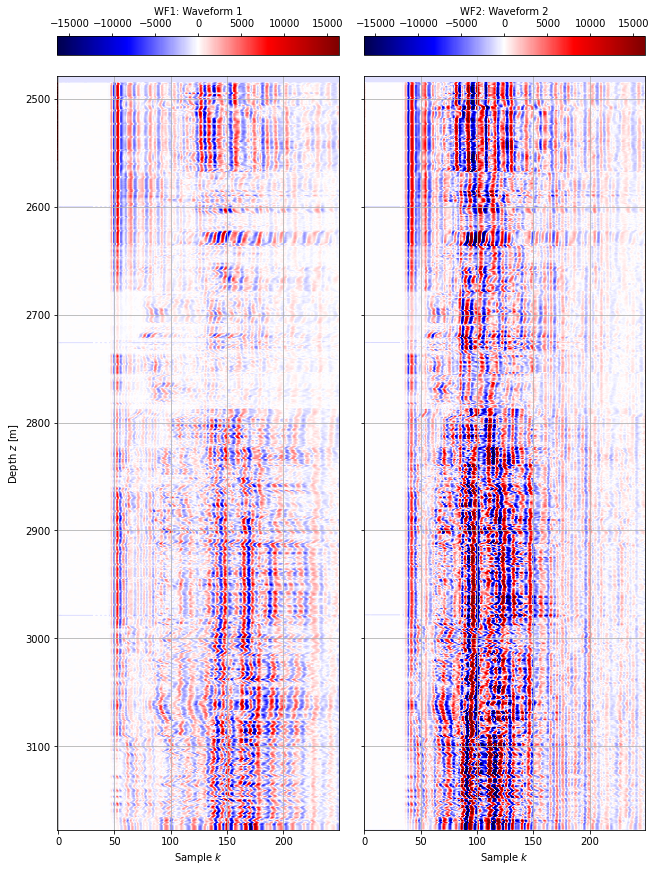

In [72]:
# Determine the maximum absolute value of WF1 and WF2 so that we can balance the colormap around 0
wf_max = max(np.max(np.abs(curves20B['WF1'])), np.max(np.abs(curves20B['WF2'])))
wf_lim = 0.5 * wf_max

# Parameters for plotting the waveforms
wf_pltargs = {
    'cmap': 'seismic',
    'vmin': -wf_lim,
    'vmax': wf_lim,
}

wf_samples = np.arange(wf1.dimension[0])   # x values to use in plotting

# Create figure and axes
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(9, 12), constrained_layout=True)

# Plot WF1 as an image
ax = axes[0]
im = paint_channel(ax, curves20B['WF1'], curves20B[frame20B.index], wf_samples, **wf_pltargs)
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label(f'{wf1.name}: {wf1.long_name}')
ax.set_ylabel('Depth $z$ [m]')

# Plot WF2 as an image
ax = axes[1]
im = paint_channel(ax, curves20B['WF2'], curves20B[frame20B.index], wf_samples, **wf_pltargs)
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label(f'{wf2.name}: {wf2.long_name}')

for ax in axes:
    ax.set_xlabel('Sample $k$')
    ax.grid(True)

Find time axis of sonic waveforms

In [74]:
# Get the metadata related to TT1 and TT2
tt1 = get_channel(frame20B, 'TT1')
tt2 = get_channel(frame20B, 'TT2')

Be careful with applied delay (DDEL)

In [75]:
wf_Ts = 10e-6     # Assumed waveform sampling period in seconds, i.e. time between samples
wf_Fs = 1/wf_Ts   # Assumed waveform sampling rate in Hertz, i.e. frequency of sampling
wf_t = wf_Ts * np.arange(wf1.dimension[0])   # Assumed time axis for the waveforms

Plot waveforms with travel time

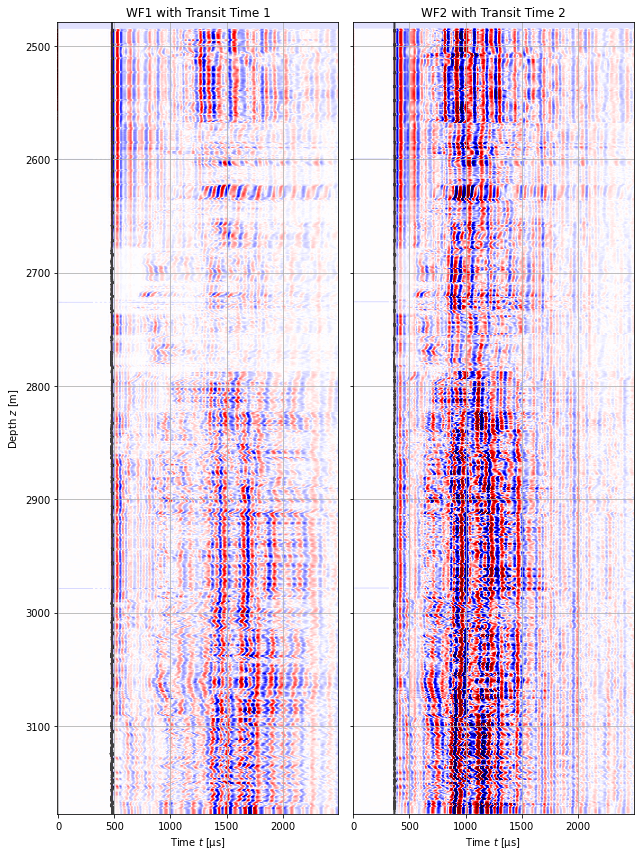

In [77]:
# Create figure and axes
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(9, 12))

# Plot WF1 as an image
ax = axes[0]
paint_channel(ax, curves20B['WF1'], curves20B[frame20B.index], wf_t*1e6, **wf_pltargs)
ax.plot(curves20B['TT1'], curves20B[frame20B.index], color='k', alpha=0.75, linewidth=2)
ax.set_ylabel('Depth $z$ [m]')
ax.set_title(f'{wf1.name} with {tt1.long_name}')

# Plot WF2 as an image
ax = axes[1]
paint_channel(ax, curves20B['WF2'], curves20B[frame20B.index], wf_t*1e6, **wf_pltargs)
ax.plot(curves20B['TT2'], curves20B[frame20B.index], color='k', alpha=0.75, linewidth=2)
ax.set_title(f'{wf2.name} with {tt2.long_name}')

for ax in axes:
    ax.set_xlabel('Time $t$ [µs]')
    ax.grid(True)

fig.set_tight_layout(True)

Compare individual waveforms at same depth

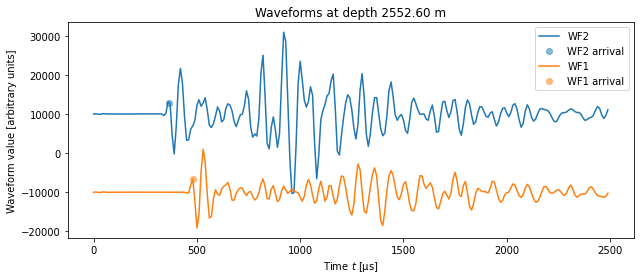

In [76]:
# Choose the depth index at which to plot the waveforms
i_wf = 12300

# Determine where to put the arrival times
tt2_t = curves20B['TT2'][i_wf]
tt2_y = np.interp(tt2_t, wf_t*1e6, curves20B['WF2'][i_wf, :])
tt1_t = curves20B['TT1'][i_wf]
tt1_y = np.interp(tt1_t, wf_t*1e6, curves20B['WF1'][i_wf, :])

shift = 1e4   # Vertical shift for both waveforms

fig, ax = plt.subplots(figsize=(9, 4))

[wf2_line] = ax.plot(wf_t*1e6, curves20B['WF2'][i_wf, :]+1e4, label='WF2')
ax.plot(tt2_t, tt2_y+shift, 'o', color=wf2_line.get_color(), alpha=0.5, label='WF2 arrival')

[wf1_line] = ax.plot(wf_t*1e6, curves20B['WF1'][i_wf, :]-1e4, label='WF1')
ax.plot(tt1_t, tt1_y-shift, 'o', color=wf1_line.get_color(), alpha=0.5, label='WF1 arrival')

ax.set_xlabel('Time $t$ [µs]')
ax.set_ylabel('Waveform value [arbitrary units]')
ax.set_title(f'Waveforms at depth {curves20B[frame20B.index][i_wf]:.2f} m')
ax.legend()
fig.set_tight_layout(True)

Check frequency spectrum

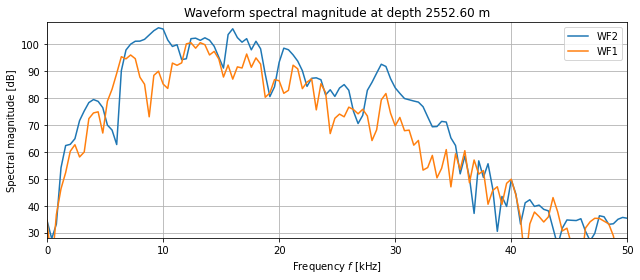

In [78]:
# Create a von Hann time window
n_samp = wf1.dimension[0]
hann_window = np.hanning(n_samp)

# Determine the spectral magnitude of the windowed signals
wf1_rfft = np.fft.rfft(hann_window*curves20B['WF1'][i_wf, :])
wf1_specmag = 20*np.log10(np.abs(wf1_rfft))
wf2_rfft = np.fft.rfft(hann_window*curves20B['WF2'][i_wf, :])
wf2_specmag = 20*np.log10(np.abs(wf2_rfft))
wf_f = np.fft.rfftfreq(n_samp, 10e-6)

wf_specmag_max = max(np.max(wf1_specmag), np.max(wf2_specmag))

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(wf_f/1e3, wf2_specmag, label='WF2')
ax.plot(wf_f/1e3, wf1_specmag, label='WF1')
ax.set_ylim(wf_specmag_max - 78, wf_specmag_max + 2)
ax.set_xlim(0, 50)
ax.set_xlabel('Frequency $f$ [kHz]')
ax.set_ylabel('Spectral magnitude [dB]')
ax.set_title(f'Waveform spectral magnitude at depth {curves20B[frame20B.index][i_wf]:.2f} m')
ax.legend()
ax.grid(True)
fig.set_tight_layout(True)

### VDL Channel

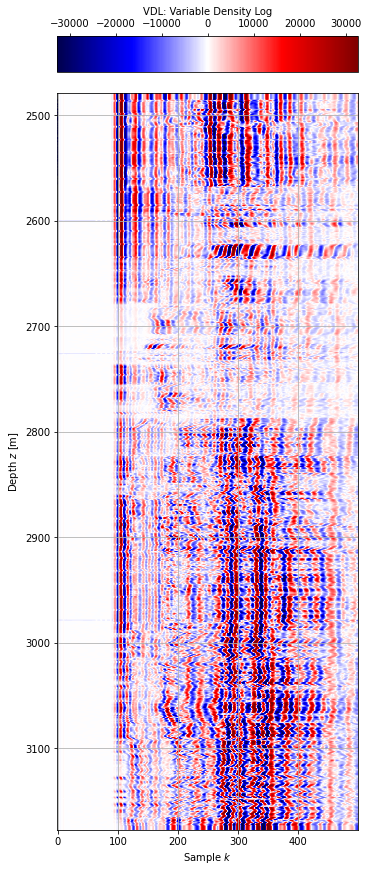

In [79]:
vdl = get_channel(frame20B, 'VDL')

# Determine the maximum absolute value of VDL so that we can balance the colormap around 0
vdl_max = np.max(np.abs(curves20B['VDL']))
vdl_lim = 1 * vdl_max

# Parameters for matplotlib.imshow
vdl_pltargs = {
    'cmap': 'seismic',
    'vmin': -vdl_lim,
    'vmax': vdl_lim,
}

vdl_samples = np.arange(vdl.dimension[0])

# Plot VDL
fig, ax = plt.subplots(figsize=(5,12), constrained_layout=True)
im = paint_channel(ax, curves20B['VDL'], curves20B[frame20B.index], vdl_samples, **vdl_pltargs)
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label(f'{vdl.name}: {vdl.long_name}')
ax.set_ylabel('Depth $z$ [m]')
ax.set_xlabel('Sample $k$')
ax.grid(True)

VDL plot with WF1

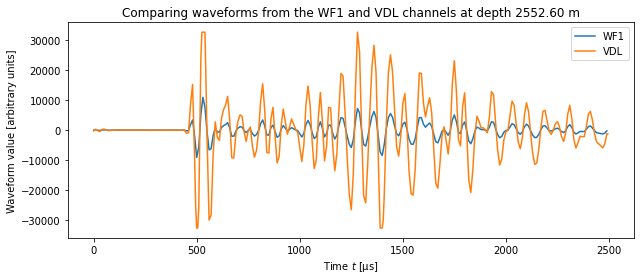

In [80]:
# Calculate the VDL time axis
vdl_Ts = wf_Ts/2
vdl_t = vdl_Ts * np.arange(vdl.dimension[0])

# Plot WF1 and VDL
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(wf_t*1e6, curves20B['WF1'][i_wf, :], label='WF1')
ax.plot(vdl_t*1e6, curves20B['VDL'][i_wf, :], label='VDL')
ax.set_title(f'Comparing waveforms from the WF1 and VDL channels at depth {curves20B[frame20B.index][i_wf]:.2f} m')
ax.set_xlabel('Time $t$ [µs]')
ax.set_ylabel('Waveform value [arbitrary units]')
ax.legend()
fig.set_tight_layout(True)

Check scale factor

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


VDL/WF1 vdl_scaling factor: 4.55906976744186


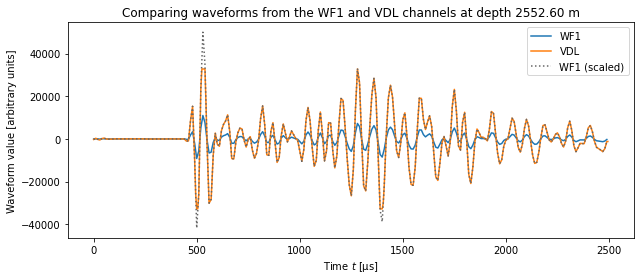

In [81]:
vdl_scaling = np.nanmedian(curves20B['VDL'][:, ::2] / curves20B['WF1'])
print('VDL/WF1 vdl_scaling factor:', vdl_scaling)

# Plot the comparison
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(wf_t*1e6, curves20B['WF1'][i_wf, :], label='WF1')
ax.plot(vdl_t*1e6, curves20B['VDL'][i_wf, :], label='VDL')
ax.plot(wf_t*1e6, vdl_scaling*curves20B['WF1'][i_wf, :], ':', color='0.4', label='WF1 (scaled)')
ax.set_title(f'Comparing waveforms from the WF1 and VDL channels at depth {curves20B[frame20B.index][i_wf]:.2f} m')
ax.set_xlabel('Time $t$ [µs]')
ax.set_ylabel('Waveform value [arbitrary units]')
ax.legend()
fig.set_tight_layout(True)

VDL is same WF1 with twice samplig rate and a clip limit

In [82]:
print(f'VDL value range: [{np.min(curves20B["VDL"])}, {np.max(curves20B["VDL"])}]')
print('Numpy datatype for the VDL channel:', curves20B['VDL'].dtype)
type_info = np.iinfo(curves20B['VDL'].dtype)
print(f'Range of {curves20B["VDL"].dtype}: [{type_info.min}, {type_info.max}]')

VDL value range: [-32767, 32767]
Numpy datatype for the VDL channel: int16
Range of int16: [-32768, 32767]


### CBL channel
check [Well Cementing book](https://www.slb.com/-/media/files/ce/other/well-cementing-book.ashx)

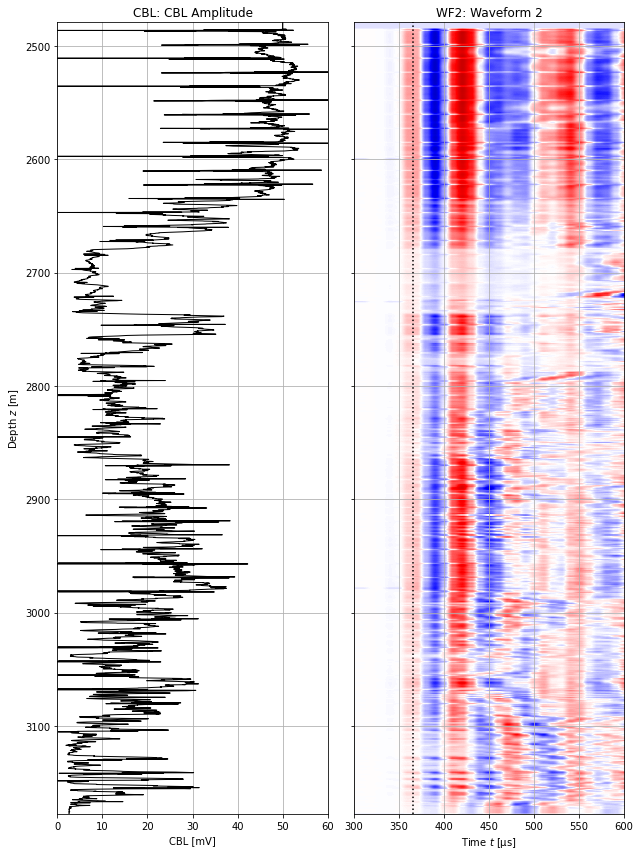

In [84]:
# The CBL channel is in frame 60B
frame60B = f.object('FRAME', '60B')
index60B = index_of(frame60B) 
curves60B = frame60B.curves()

# Convert the index to metres if needed
if index60B.units == '0.1 in':
    curves60B[index60B.name] *= 0.00254

# Get CBL channel metadata
cbl = get_channel(frame60B, 'CBL')

fig, axes = plt.subplots(ncols=2, figsize=(9, 12), sharey=True)

# Plot CBL
ax = axes[0]
ax.plot(curves60B['CBL'], curves60B[frame60B.index], color='k', linewidth=1)
ax.set_xlim(0, 60)
ax.set_xlabel('CBL [mV]')
ax.set_ylabel('Depth $z$ [m]')
ax.set_title(f'{cbl.name}: {cbl.long_name}')
ax.grid(True)

# Plot WF2 around the waveform arrival
ax = axes[1]
paint_channel(ax, curves20B['WF2'], curves20B[frame20B.index], wf_t*1e6,
              vmin=-0.5*wf_max, vmax=0.5*wf_max, cmap='seismic')
ax.set_xlabel('Time $t$ [µs]')
ax.set_title(f'{wf2.name}: {wf2.long_name}')
ax.grid(True)
ax.set_xlim(300, 600)
ax.axvline(365, linestyle=':', color='k')

fig.set_tight_layout(True)

Where WF2 is strong, CBL is high.
Where WF2 is faint, CBL is low.

Find the values of the $E_1$ peak in arbitrary units for every waveform to show that its overall shape matches the CBL curve. To do this:

_   Upsample every WF2 waveform using a Fourier method

_   Find the peak sample of each waveform around the expected location of the peak

_   Estimate the peak amplitude more finely by means of a quadratic fit around the three peak samples.

To compare the $E_1$ values with the values in the CBL channel, calculate a conversion factor $a$ from a linear fit

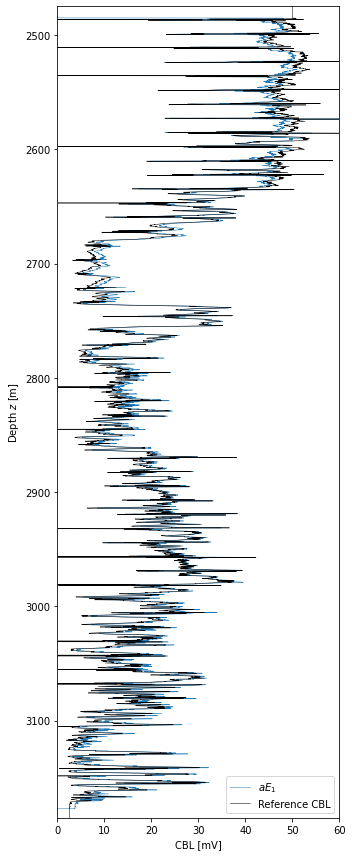

In [85]:
def waveform_E1(wfs, k_window):
    """Returns the first peak amplitudes E1 from an array of waveforms, searching only through samples in k_window"""
    n_wf = wfs.shape[0]
    wf_E1s = np.zeros(n_wf)
    
    for i in range(n_wf):
        k_max = k_window[0] + np.argmax(wfs[i][k_window])
        fit_ks = k_max + np.array([-1,0,1])
        fit = np.polyfit(fit_ks, wfs[i, fit_ks], 2)
        k_max = - fit[1] / (2 * fit[0])
        wf_E1s[i] = np.polyval(fit, k_max)

    return wf_E1s

# Determine E1 from the upsampled windowed waveforms
window = signal.tukey(250, 20/250)
upsampled_wfs, upsampled_wfs_t = signal.resample(window*curves20B['WF2'], 2500, wf_t, axis=1)
k_window = 365 + np.arange(-20, 21)
wf2_E1 = waveform_E1(upsampled_wfs, k_window)

# Interpolate waveform peaks to the CBL frame depths
wf2_E1 = np.interp(curves60B[frame60B.index], curves20B[frame20B.index][::-1], wf2_E1[::-1])

# Find a linear scaling between wf2_El and CBL as an intercept-free linear fit
mask = np.logical_and(curves60B['CBL'] > 0, wf2_E1 > 0)   # Omit missing data and invalid data
fit = np.linalg.lstsq(wf2_E1[mask][:,np.newaxis], curves60B['CBL'][mask], rcond=None)
a = fit[0][0]

# Plot comparison
fig, ax = plt.subplots(figsize=(5, 12))
ax.plot(wf2_E1*a, curves60B[frame60B.index], linewidth=0.5, label='$a E_1$')
ax.plot(curves60B['CBL'], curves60B[frame60B.index], 'k', linewidth=0.5, label='Reference CBL')
ax.set_xlim(0, 60)
ax.set_ylim(np.max(curves60B[frame60B.index]), np.min(curves60B[frame60B.index]))
ax.legend()
ax.set_xlabel('CBL [mV]')
ax.set_ylabel('Depth $z$ [m]');

fig.set_tight_layout(True)

$a E_1$ have the same shape as the reference CBL channel, but deviates for particularly large or small CBL values. 

Check at how the scaling matches the joint distribution of $E_1$ and CBL values, and how the absolute difference $|aE_1 - \mathrm{CBL}|$ is distributed:

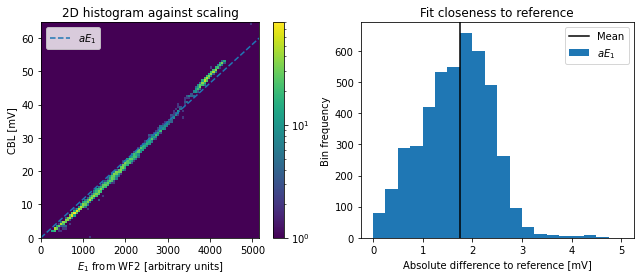

In [86]:
fig, axes = plt.subplots(ncols=2, figsize=(9,4))

cmap = copy.copy(mpl.cm.get_cmap('viridis'))
cmap.set_bad(cmap.colors[0])

# Plot a 2D histogram of E_1 values against the values from the CBL channel, and show the scaling
ax = axes[0]
plot_max = (max(wf2_E1), max(curves60B['CBL']))
hist = ax.hist2d(wf2_E1, curves60B['CBL'], norm=mpl.colors.LogNorm(), cmap=cmap,
                 bins=(np.linspace(0, plot_max[0], 100), np.linspace(0, plot_max[1], 100)))
ax.plot((0, plot_max[0]), (0, a*plot_max[0]), '--', label='$a E_1$')
fig.colorbar(hist[3], ax=ax)
ax.set_xlim(0, plot_max[0])
ax.set_ylim(0, plot_max[1])
ax.set_title('2D histogram against scaling')
ax.set_xlabel('$E_1$ from WF2 [arbitrary units]')
ax.set_ylabel('CBL [mV]')
ax.legend()

# Plot a histogram showing the match
ax = axes[1]
x = np.abs(wf2_E1[mask]*a - curves60B['CBL'][mask])
ax.hist(x, bins=np.arange(0,5.25,0.25), label='$a E_1$')
ax.axvline(np.mean(x), color='k', label='Mean')
ax.legend()
ax.set_title('Fit closeness to reference')
ax.set_xlabel('Absolute difference to reference [mV]')
ax.set_ylabel('Bin frequency')

fig.set_tight_layout(True)

### Ultrasonic tool

In [90]:
usit = f.object('TOOL', 'USIT')
usit.describe()

----
Tool
----
name   : USIT
origin : 57
copy   : 0

Description    : Ultrasonic Imaging
Trademark name : USIT-E
Generic name   : USIT-E

Channels   : AWAV_RF                  MDR                      U044
             U016                     U023                     U036
             U008                     AIMN_RF                  RB
             U022                     AZEC_EXT                 IDQC
             RSAV                     AWAV                     U020
             U024                     U051                     IRAV_EXT
             T2BK                     IRMN_EXT                 AWMN_RF
             U063                     U027                     U009
             U014                     U035                     WPKA
             AZEC                     U056                     THBK
             AI_MICRO_DEBONDING_IMAGE GASR                     IRBK
             CZMD                     IRMN                     ERMN
             USGI                     U04

USIT parameters

In [91]:
usit_param_table = summarize(usit.parameters, name='Name', long_name='Long name', values='Value(s)')
usit_param_table.sort_values('Name')

Name  ...               Value(s)
36            AFVU  ...                  [Off]
46            AGMN  ...                  [-12]
47            AGMX  ...                   [40]
7             BERJ  ...                   [ON]
17            CMTY  ...       [Regular Cement]
41          C_ALGO  ...                 [CCLU]
38         C_BLANK  ...                   [12]
3           C_DLEN  ...                   [24]
44           C_JNO  ...                    [0]
34         C_MFILT  ...                   [No]
0            C_MPL  ...                   [24]
29           C_NUP  ...                  [Yes]
11           C_TPC  ...                   [50]
20          C_WIND  ...                  [600]
42             DOT  ...    [4.874000072479248]
28            EMXV  ...                   [90]
8          ENABLED  ...                  [Yes]
21         ENABLED  ...                   [No]
5          ENABLED  ...                   [No]
23         ENABLED  ...                   [No]
4          ENABLED  ...                   [No]
15         ENABLED  ...                   [No]
26         ENABLED  ...                   [No]
27            HRES  ...                [5 deg]
9   MAX_TOOL_SPEED  ...     [2057.39990234375]
13            NPPW  ...                  [120]
18            NWPD  ...                   [72]
32           OPLEV  ...                 [OPT2]
10            RCOD  ...                  [7.0]
12            RCSO  ...   [1.3779499530792236]
1             RCTH  ...    [0.295199990272522]
25            SDNV  ...                    [5]
48          SDTHOR  ...                  [0.5]
49          SDTVER  ...  [0.30000001192092896]
50            SUBT  ...                [10INC]
16            TCUB  ...                 [VXLP]
37            THDH  ...                [130.0]
14            THDL  ...                 [70.0]
35            THDP  ...          [Fundamental]
45             TVD  ...                  [0.0]
56     U-USIT_DDT5  ...               [0_NONE]
51            ULOG  ...              [MEASURE]
52            UMAO  ...                 [18.0]
24            UMFR  ...             [333333.0]
53            UPAT  ...                 [300K]
39            USFR  ...             [500000.0]
54            USTO  ...                 [-2.0]
55            USUB  ...                [10INC]
57            UWKM  ...             [D606005L]
6             VCAS  ...   [51.400001525878906]
19            VRES  ...              [6.0INCH]
40            WINB  ...    [53.79532241821289]
31            WINE  ...    [120.3934326171875]
2             WLEN  ...    [32.32666778564453]
33            ZCAS  ...                [46.25]
43            ZINI  ...                 [-1.0]
30            ZTCM  ...   [2.5999999046325684]
22            ZTGS  ...  [0.30000001192092896]

[58 rows x 3 columns]

USIT channels

In [92]:
usit_channel_table = summarize(usit.channels, name='Name', long_name='Long name', units='Units',
                                              dimension='Dimension', frame='Frame')
usit_channel_table.sort_values('Name')

Name  ...       Frame
88                       AGMA  ...  Frame(60B)
54                       AGMI  ...  Frame(60B)
112                      AIAV  ...  Frame(60B)
98                    AIAV_RF  ...  Frame(60B)
49                       AIBK  ...  Frame(60B)
89                       AIMN  ...  Frame(60B)
7                     AIMN_RF  ...  Frame(60B)
55                       AIMX  ...  Frame(60B)
90                    AIMX_RF  ...  Frame(60B)
30   AI_MICRO_DEBONDING_IMAGE  ...  Frame(60B)
13                       AWAV  ...  Frame(60B)
0                     AWAV_RF  ...  Frame(60B)
132                      AWBK  ...  Frame(60B)
147                   AWBK_RF  ...  Frame(60B)
133                      AWMN  ...  Frame(60B)
20                    AWMN_RF  ...  Frame(60B)
106                      AWMX  ...  Frame(60B)
120                   AWMX_RF  ...  Frame(60B)
27                       AZEC  ...  Frame(60B)
10                   AZEC_EXT  ...  Frame(60B)
141                   AZEC_RF  ...  Frame(60B)
61                       BPRE  ...  Frame(60B)
50                       CCLU  ...  Frame(60B)
137                      CEMR  ...  Frame(60B)
56                       CFVL  ...  Frame(60B)
33                       CZMD  ...  Frame(60B)
44                       ECCE  ...  Frame(60B)
45                 ECCEEXT_RF  ...  Frame(60B)
96                   ECCE_EXT  ...  Frame(60B)
110                   ECCE_RF  ...  Frame(60B)
128                      ERAV  ...  Frame(60B)
127                  ERAV_EXT  ...  Frame(60B)
148                   ERAV_RF  ...  Frame(60B)
107                  ERBA_EXT  ...  Frame(60B)
142                      ERBK  ...  Frame(60B)
134                  ERBK_EXT  ...  Frame(60B)
83                   ERBN_EXT  ...  Frame(60B)
35                       ERMN  ...  Frame(60B)
53                   ERMN_EXT  ...  Frame(60B)
149                   ERMN_RF  ...  Frame(60B)
85                       ERMX  ...  Frame(60B)
73                   ERMX_EXT  ...  Frame(60B)
150                   ERMX_RF  ...  Frame(60B)
104                      ERNO  ...  Frame(60B)
31                       GASR  ...  Frame(60B)
151                      GNMN  ...  Frame(60B)
152                      GNMX  ...  Frame(60B)
153                      HRTT  ...  Frame(60B)
11                       IDQC  ...  Frame(60B)
79                       IRAV  ...  Frame(60B)
17                   IRAV_EXT  ...  Frame(60B)
154                   IRAV_RF  ...  Frame(60B)
32                       IRBK  ...  Frame(60B)
144                  IRBK_EXT  ...  Frame(60B)
155                   IRBK_RF  ...  Frame(60B)
34                       IRMN  ...  Frame(60B)
19                   IRMN_EXT  ...  Frame(60B)
156                   IRMN_RF  ...  Frame(60B)
105                      IRMX  ...  Frame(60B)
124                  IRMX_EXT  ...  Frame(60B)
157                   IRMX_RF  ...  Frame(60B)
82                       IRNO  ...  Frame(60B)
1                         MDR  ...  Frame(60B)
158                     MLOSS  ...  Frame(60B)
8                          RB  ...  Frame(60B)
159                   RB_USIT  ...  Frame(60B)
12                       RSAV  ...  Frame(60B)
101                      T1BK  ...  Frame(60B)
108                      T2AV  ...  Frame(60B)
18                       T2BK  ...  Frame(60B)
160                      THAV  ...  Frame(60B)
161                   THAV_RF  ...  Frame(60B)
29                       THBK  ...  Frame(60B)
162                   THBK_RF  ...  Frame(60B)
163                      THMN  ...  Frame(60B)
164                   THMN_RF  ...  Frame(60B)
165                      THMX  ...  Frame(60B)
166                   THMX_RF  ...  Frame(60B)
116                      THNO  ...  Frame(60B)
167                      TTAV  ...  Frame(60B)
46                       TTBK  ...  Frame(60B)
168                      TTMN  ...  Frame(60B)
169                      TTMX  ...  Frame(60B)
170                     U-ED1  ...  Frame(60B)
171                    U-ED10 

Azimuthal channels

In [94]:
# Get the value of the NWPD parameter
nwpd = f.object('PARAMETER', 'NWPD').values[0]

# Show all azimuthal channels
usit_channel_table[usit_channel_table['Dimension'] == nwpd].sort_values('Name')

Name  ...       Frame
49                       AIBK  ...  Frame(60B)
30   AI_MICRO_DEBONDING_IMAGE  ...  Frame(60B)
132                      AWBK  ...  Frame(60B)
147                   AWBK_RF  ...  Frame(60B)
107                  ERBA_EXT  ...  Frame(60B)
142                      ERBK  ...  Frame(60B)
134                  ERBK_EXT  ...  Frame(60B)
83                   ERBN_EXT  ...  Frame(60B)
32                       IRBK  ...  Frame(60B)
144                  IRBK_EXT  ...  Frame(60B)
155                   IRBK_RF  ...  Frame(60B)
101                      T1BK  ...  Frame(60B)
18                       T2BK  ...  Frame(60B)
29                       THBK  ...  Frame(60B)
162                   THBK_RF  ...  Frame(60B)
46                       TTBK  ...  Frame(60B)
206                      UFLG  ...  Frame(60B)
42                       UPGA  ...  Frame(60B)
113                      UTIM  ...  Frame(60B)
119                      WAGN  ...  Frame(60B)
51                       WFDL  ...  Frame(60B)
26                       WPKA  ...  Frame(60B)

[22 rows x 5 columns]

Check more channels

In [95]:
# All the Channels we want are in Frame(60B)
frame60B = f.object('FRAME', '60B')
index60B = index_of(frame60B) 
curves60B = frame60B.curves()

# Convert the index to metres if needed
if index60B.units == '0.1 in':
    curves60B[index60B.name] *= 0.00254

# Get the metadata of each channel
aibk = get_channel(frame60B, 'AIBK')
t2bk = get_channel(frame60B, 'T2BK')
erbk = get_channel(frame60B, 'ERBK')
irbk = get_channel(frame60B, 'IRBK')


Each array corresponding to the channel curves, e.g. $\mathtt{AIBK}(i,j)$, has two dimensions. The first dimension is depth. The second is the azimuthal angle. The actual azimuthal angle is given from the NWPD parameter as $\varphi_j = j \Delta \varphi$, where $\Delta\varphi = 360/\mathrm{NWPD}$:

In [97]:
dang = 360//nwpd
ang = dang * np.arange(nwpd)

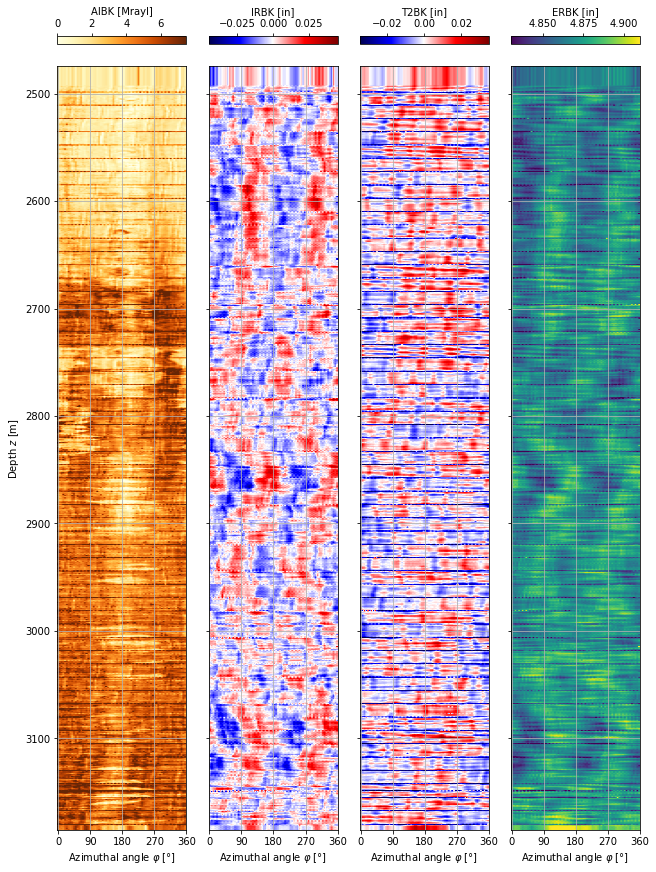

In [98]:
fig, axes = plt.subplots(ncols=4, figsize=(9,12), sharey=True, constrained_layout=True)

ax = axes[0]
im = paint_channel(ax, curves60B['AIBK'], curves60B[frame60B.index], ang, cmap='YlOrBr', vmin=0, vmax=7.5)
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label(f'AIBK [{aibk.units}]')
ax.set_ylabel('Depth $z$ [m]')

ax = axes[1]
im = paint_channel(ax, curves60B['IRBK'], curves60B[frame60B.index], ang, cmap='seismic', vmin=-0.045, vmax=0.045)
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label(f'IRBK [{irbk.units}]')

ax = axes[2]
im = paint_channel(ax, curves60B['T2BK'], curves60B[frame60B.index], ang, cmap='seismic', vmin=-0.035, vmax=0.035)
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label(f'T2BK [{t2bk.units}]')

ax = axes[3]
im = paint_channel(ax, curves60B['ERBK'], curves60B[frame60B.index], ang, vmin=4.83, vmax=4.91)
cbar = fig.colorbar(im, ax=ax, location='top')
cbar.set_label(f'ERBK [{erbk.units}]')

for ax in axes:
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.grid(True)
    ax.set_xlabel('Azimuthal angle $\\varphi$ [°]')